In [1]:
from util.data import (
    load_combined_grammar_data,
    load_grammar_data_by_category,
    load_numerical_data,
)
from util.numerical import load_word_problems_data
from pprint import pprint
from module.head_select import head_select
from util.model import get_device_memory_report
from module.blocked_attention import load_altered_attention_model, get_model_dimensions, disable_head, enable_head, get_disabled_heads
from util.chat import (
    load_embeddings_dataset,
    load_embeddings_dataset_batch,
    load_llm_generations,
)
from util.model import load_model
from plot.layer_seperation import plot_all_layers_divergence
from random import shuffle
import torch
import json

/scratch/f00561n/miniconda3/envs/thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
get_device_memory_report(device)

Device: cuda:4 [NVIDIA RTX 6000 Ada Generation]
Free Memory: 46.96/47.38 GB [99.11%]


In [3]:
gemma_9B, gemma_9B_tokenizer = load_altered_attention_model(
    "google/gemma-2-9b-it", device, model_type="gemma"
)
# qwen_8B, qwen_8B_tokenizer = load_altered_attention_model(
#     "qwen/qwen3-8b", device, model_type="qwen"
# )
# llama_8B, llama_8B_tokenizer = load_altered_attention_model(
#     "meta-llama/Llama-3.1-8B-Instruct", device, model_type="llama"
# )


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


In [5]:
numerical_data = load_numerical_data(margin=50)
shuffle(numerical_data)
numerical_data = numerical_data[:100]
numerical_embeddings = load_embeddings_dataset(
    numerical_data,
    qwen_8B,
    qwen_8B_tokenizer,
    device,
    types_=["mcq", "bin", "raw"],
    use_tqdm=True,
    problem_type="arithmetic",
    use_system_message=False,
)

0it [00:00, ?it/s]

100it [00:53,  1.87it/s]


In [4]:
grammar_data = load_grammar_data_by_category(
    category="linguistics_term", value="quantifiers", sample_rate=1
)
shuffle(grammar_data)
grammar_data = grammar_data[:100]
grammar_embeddings = load_embeddings_dataset(
    grammar_data,
    gemma_9B,
    gemma_9B_tokenizer,
    device,
    types_=["mcq", "bin", "raw"],
    use_tqdm=True,
    problem_type="grammar",
    use_system_message=False,
    n_shot=0,
)

100it [00:59,  1.68it/s]


In [7]:
word_problems_data = load_word_problems_data()
word_problems_embeddings = load_embeddings_dataset(
    word_problems_data,
    qwen_8B,
    qwen_8B_tokenizer,
    device,
    types_=["mcq", "bin", "raw"],
    use_tqdm=True,
    problem_type="word_problems",
    use_system_message=False,
    n_shot=0,
)

100it [00:59,  1.67it/s]


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


def plot_all_layers_divergence(
    embeddings, method="pca", divisions=[0, 0.25, 0.5, 0.75, 1]
):
    n_types, n_divisions = len(embeddings.keys()), len(divisions)
    fig, axs = plt.subplots(
        n_types, n_divisions, figsize=(n_divisions * 3, n_types * 3)
    )
    n_layers = len(list(embeddings.values())[0][0]["states"])
    layers_idx = np.array([int((n_layers - 1) * x) for x in divisions])
    layers_idx[0] += 1
    for i, type_ in enumerate(embeddings):

        states = np.array([x["states"] for x in embeddings[type_]])
        states = np.transpose(states, (1, 0, 2))[layers_idx]
        labels = np.array([int(x["answer"]) for x in embeddings[type_]])
        for j, layer_idx in enumerate(layers_idx):
            if method == "pca":
                pca = PCA(n_components=2)
                result = pca.fit_transform(states[j])
            elif method == "tsne":
                tsne = TSNE(n_components=2, random_state=42, perplexity=50)
                result = tsne.fit_transform(states[j])
            sns.scatterplot(
                x=result[:, 0],
                y=result[:, 1],
                hue=labels,
                palette=sns.color_palette("bright", len(np.unique(labels))),
                s=10,
                ax=axs[i, j],
            )
            if i == 0:
                axs[i, j].set_title(f"Layer {layer_idx}")
            if j == 0:
                axs[i, j].set_ylabel(type_)
    plt.tight_layout()
    plt.show()

def get_linear_separation(X, y):
    pca = PCA(n_components=3)
    result = pca.fit_transform(X)
    svm = SVC(kernel="linear")
    svm.fit(result, y)
    return svm.score(result, y)

def get_mlp_separation(X, y):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # mlp = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=500)
    # mlp.fit(X_train, y_train)
    # return mlp.score(X_test, y_test)
    return get_linear_separation(X, y)

def plot_all_layers_separation(embeddings, divisions=[0, 0.25, 0.5, 0.75, 1]):
    n_types, n_divisions = len(embeddings.keys()), len(divisions)
    fig, axs = plt.subplots(
        n_types, 1, figsize=(15, 10)
    )
    n_layers = len(list(embeddings.values())[0][0]["states"])
    layers_idx = np.array([int((n_layers - 1) * x) for x in divisions])

    for i, type_ in enumerate(embeddings):
        states = np.array([x["states"] for x in embeddings[type_]])
        states = np.transpose(states, (1, 0, 2))[layers_idx]
        labels = np.array([int(x["answer"]) for x in embeddings[type_]])

        linear_seperability, mlp_seperability = [], []
        for j, layer_idx in enumerate(layers_idx):
            X, y = states[j], labels
            linear_seperability.append(get_linear_separation(X, y))
            mlp_seperability.append(get_mlp_separation(X, y))

        axs[i].plot(divisions, linear_seperability, label="Linear SVM")
        axs[i].scatter(divisions, linear_seperability)
        axs[i].plot(divisions, mlp_seperability, label="MLP")
        axs[i].scatter(divisions, mlp_seperability)

        for j, layer_idx in enumerate(layers_idx):
            axs[i].text(divisions[j], linear_seperability[j], f"{linear_seperability[j]:.2f}", ha="center", va="bottom")
            axs[i].text(divisions[j], mlp_seperability[j], f"{mlp_seperability[j]:.2f}", ha="center", va="bottom")
        axs[i].set_title(type_)
        axs[i].legend()
        


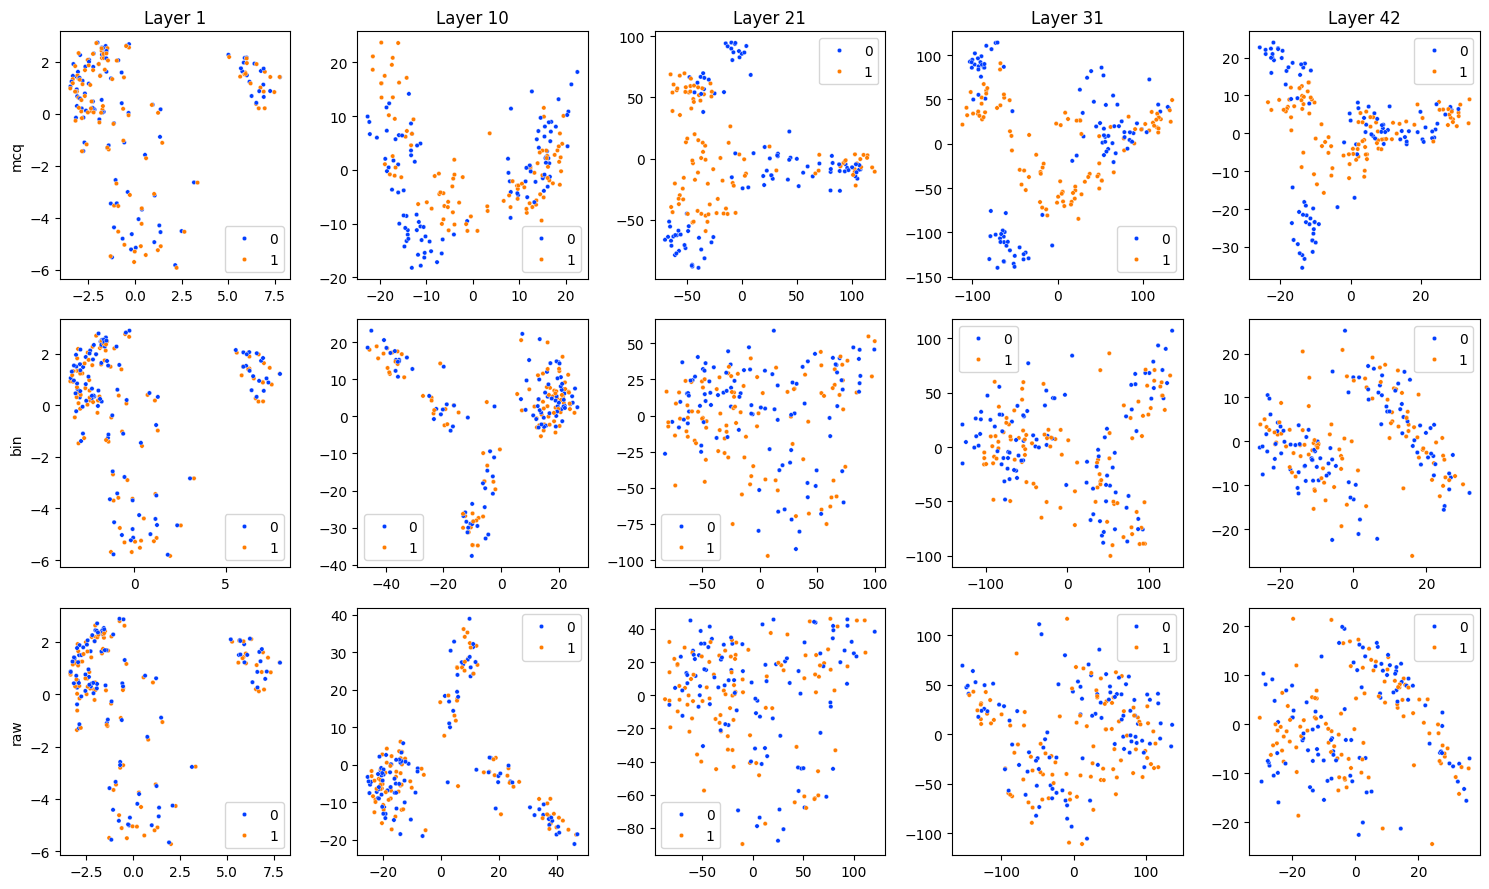

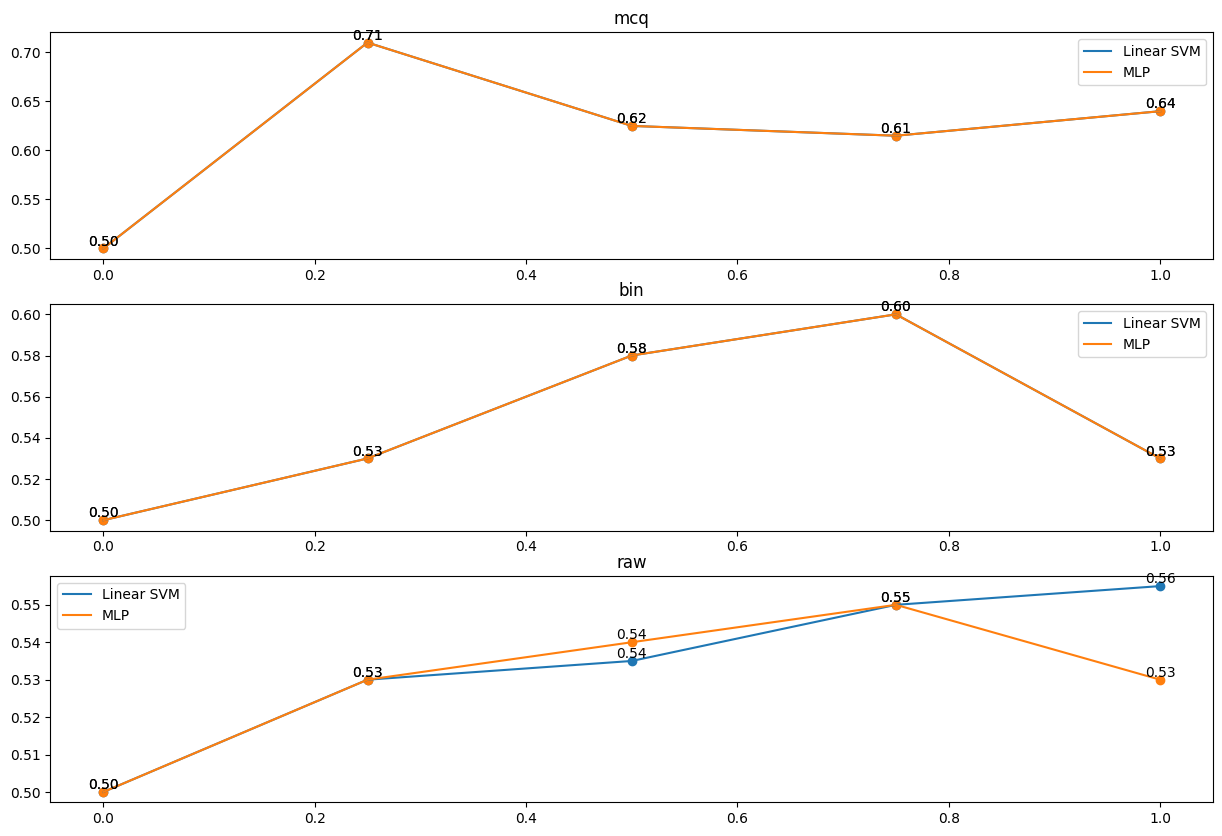

In [8]:
plot_all_layers_divergence(grammar_embeddings, method="pca")
plot_all_layers_separation(grammar_embeddings)

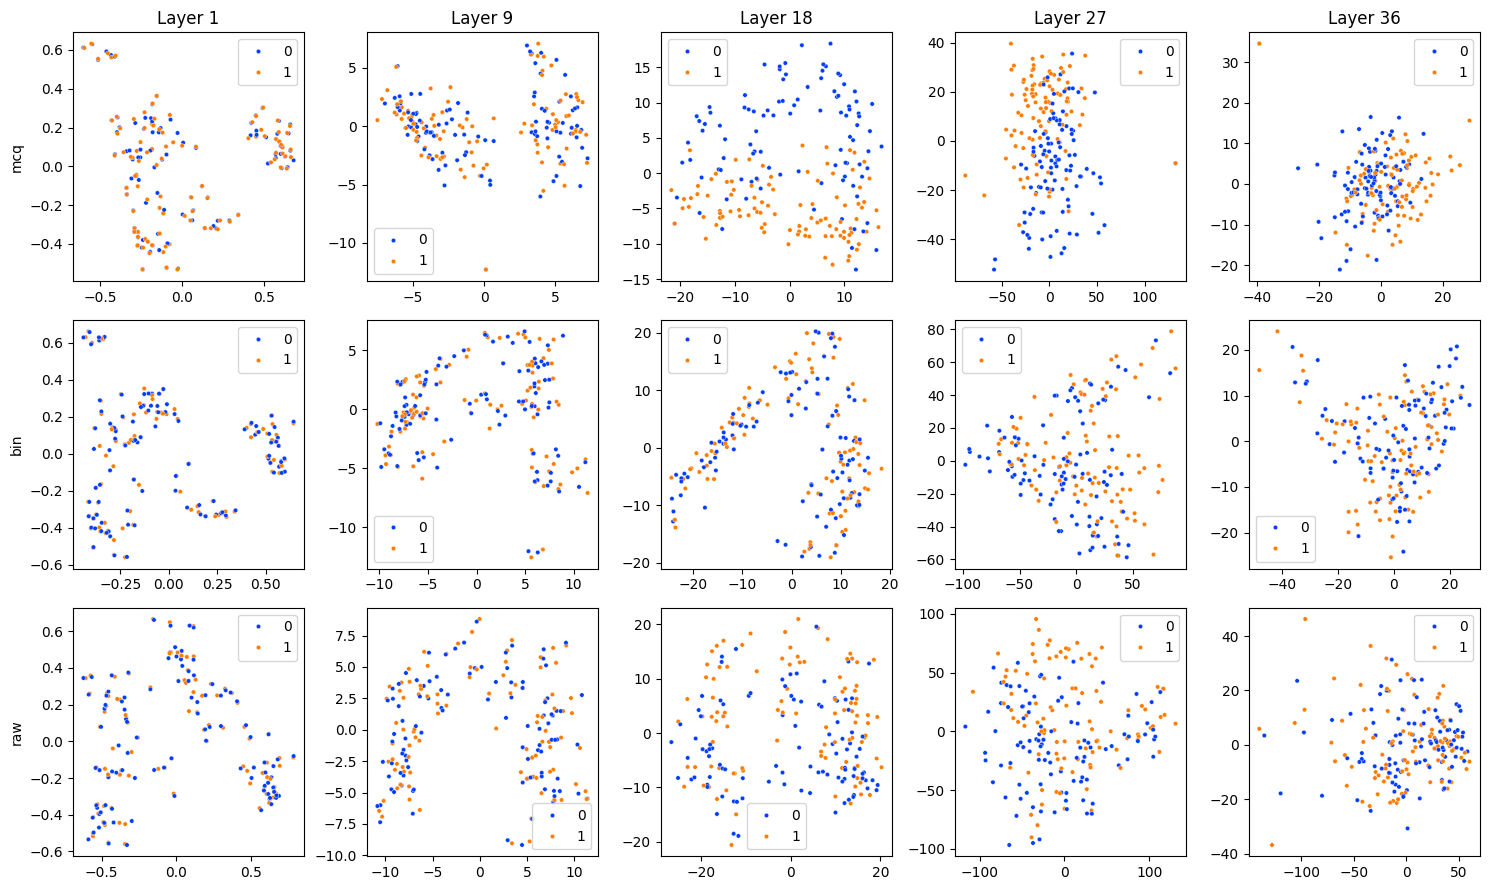

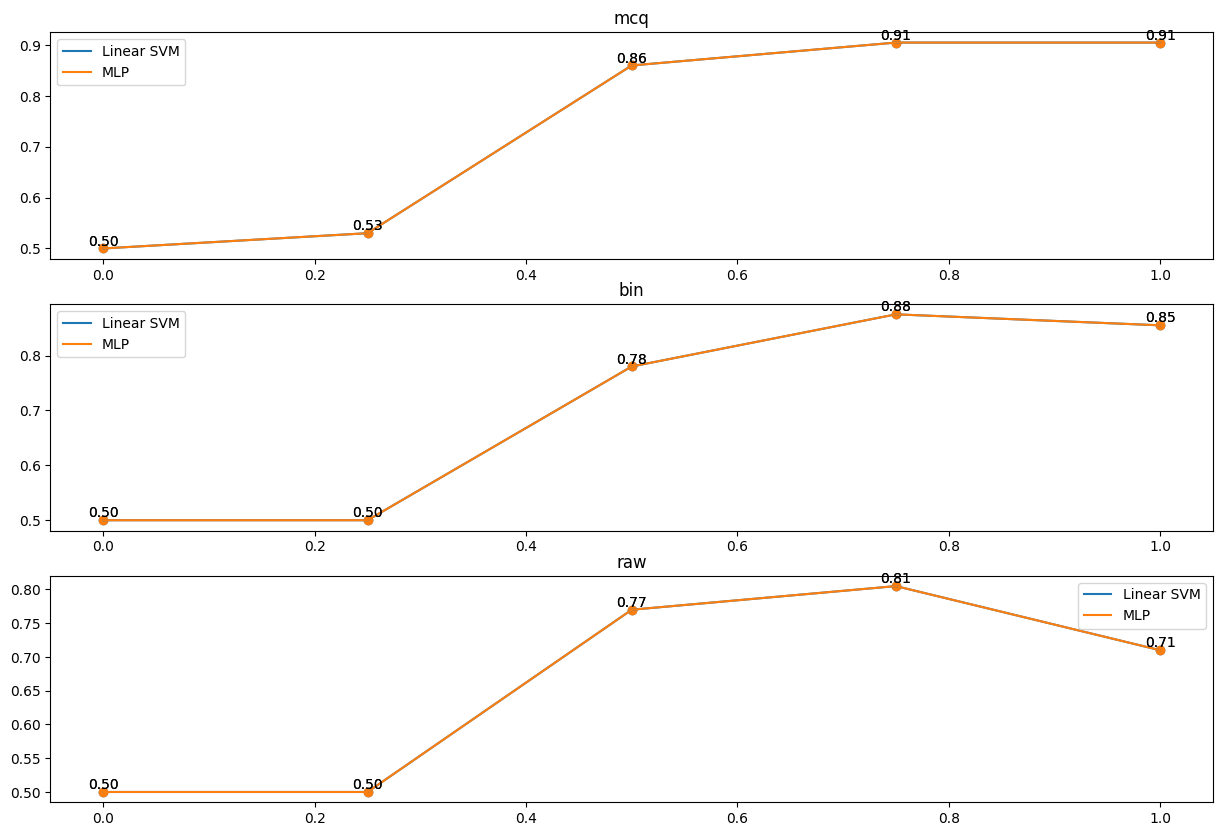

In [14]:
plot_all_layers_divergence(word_problems_embeddings, method="pca")
plot_all_layers_separation(word_problems_embeddings)

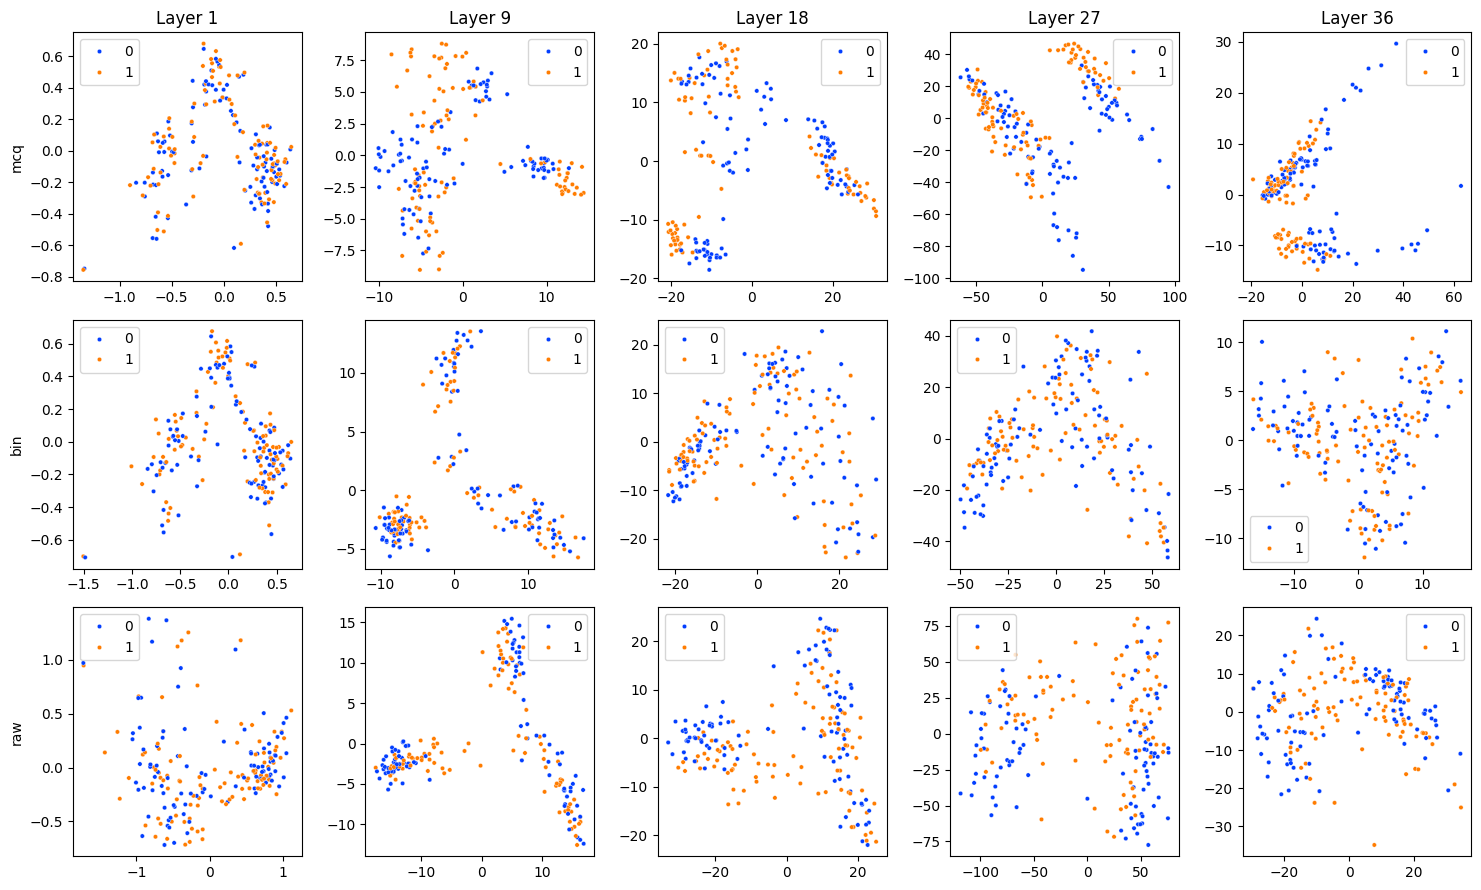

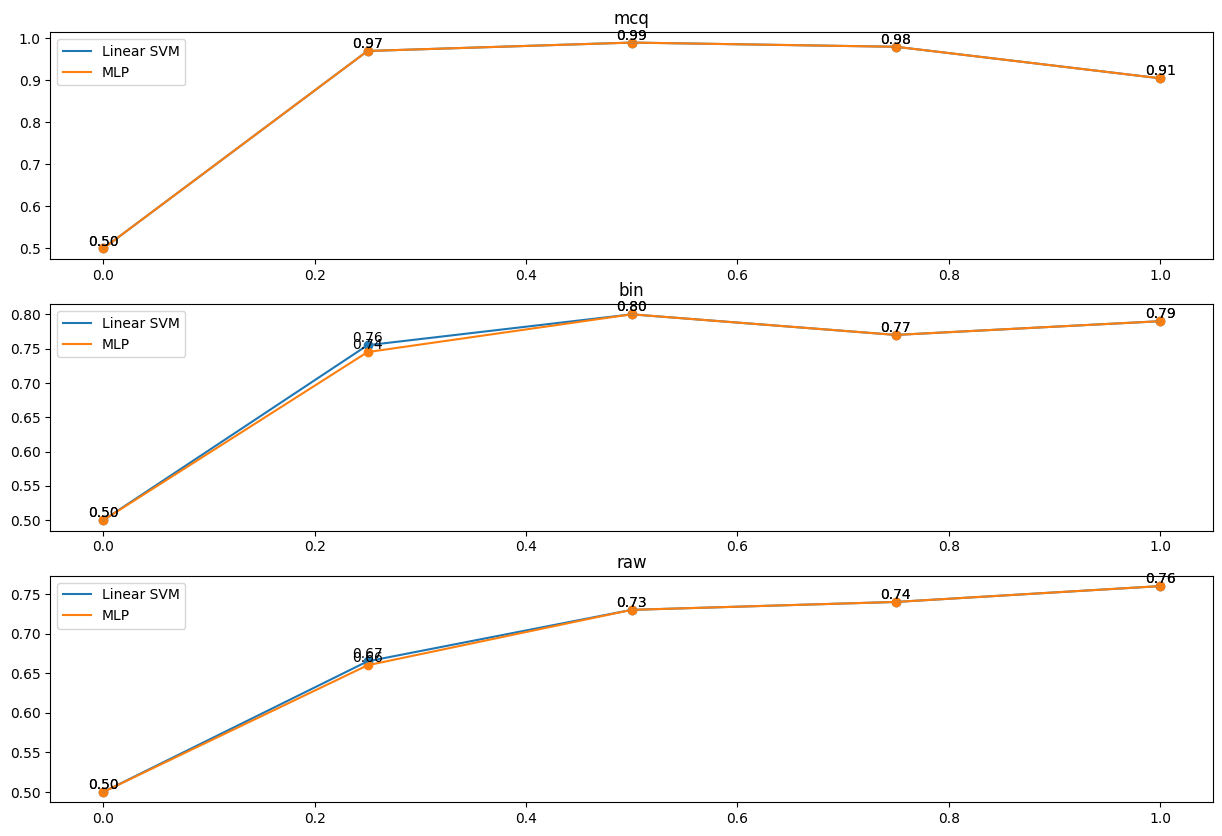

In [15]:
plot_all_layers_divergence(grammar_embeddings, method="pca")
plot_all_layers_separation(grammar_embeddings)